# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# DONE: Total number of records
n_records = data['income'].count()

# DONE: Number of records where individual's income is more than $50,000
count = 0
count = [count+1 for income in data['income'] if income == ">50K"]
n_greater_50k = sum(count)
 
# DONE: Number of records where individual's income is at most $50,000
n_at_most_50k = n_records - n_greater_50k

# DONE: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k*100.0)/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

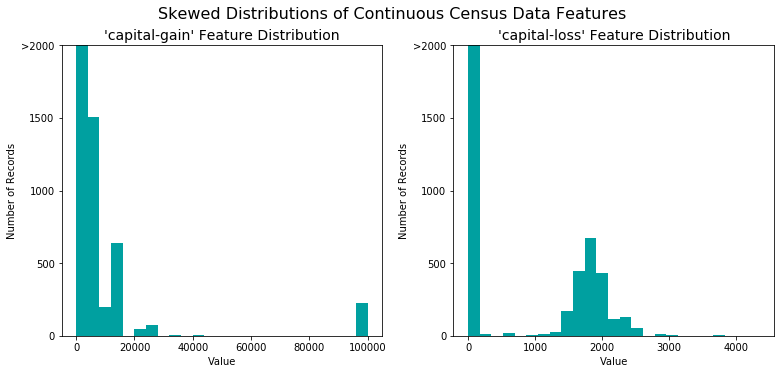

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

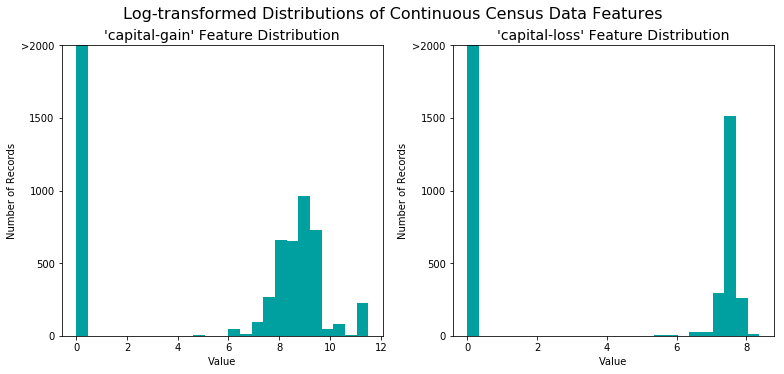

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# Done: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# DONE: Encode the 'income_raw' data to numerical values
income = pd.get_dummies(income_raw)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [8]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [10]:
# DONE: Calculate accuracy
accuracy = greater_percent / 100.

# DONE: Calculate F-score using the formula above for beta = 0.5

TP = n_greater_50k 
FP = n_at_most_50k 
FN = 0 

precision = TP/float(TP+FP)
recall = TP/float(TP+FN)
B = 0.5

fscore =  ((1+B*B)*(precision*recall)) / (B*B*precision + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: ** 
This is clearly a classification problem so i am choosing three classifiers algorithms for this project on the basis of my research and testing, done on data in next question.
### 1. Random Forest Classifier : 
   * __*Real World Application :*__ Random forest can be used for recommendation of movies to a user.
   * __*Strength :*__ 
     * Random Forest performs well with large datasets
     * It does not overfit on data
     * This algorithm can solve both type of problems i.e. classification and regression and does a decent estimation at both fronts.
     * It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
     * It is used not only for prediction, but also to assess variable importance
   * __*Weakness :*__
       * Unlike decision trees, the classifications made by random forests are difficult for humans to interpret.
       * If the data contain groups of correlated features of similar relevance for the output, then smaller groups are favored over larger groups
       * Random Forest can feel like a black box approach as we have very little control on what the model does. We can at best try different parameters and random seeds.

### 2. Ada Boost Classifier : 
   * __*Real World Application :*__ Ada Boost can be used for detecting an email as spam or not.
   * __*Strength :*__ 
     * It is fast, simple and easy to program
     * It is flexible — can combine with any learning algorithm
     * It does not require any prior knowledge about weak learner
     * It is versatile in nature i.e. 
        * It can be used with data that is textual, numeric, discrete, etc.
        * It has been extended to learning problems well beyond binary classification
   * __*Weakness :*__
        * The performance of AdaBoost depends on data and weak learner
        * It is consistent with theory, AdaBoost can fail if
            * weak classifiers is too complex i.e. overfitting can occur
            * weak classifiers is too weak i.e. underfitting can happen
       
### 3. KNeighbors Classifier : 
   * __*Real World Application :*__ K-nearest neighbor is used in retail to detect patterns in credit card usage, theft prevention in the modern retail business. 
   * __*Strength :*__ 
       * It is easy to implement.
       * It is robust to noisy training data.
       * KNN makes predictions just-in-time by calculating the similarity between an input sample and each training instance.
   * __*Weakness :*__
       * It requires need to determine value of parameter K (number of nearest neighbors)
       * Computation cost is quite high because we need to compute distance of each query instance to all training samples.
  
       
### 4. Reasons for Choosing this algorithm :
   * All of these algorithm performs really well with large datasets.
   * They do not rely only on single instance of data and therefore has very small chances of overfitting.
   * To correclty identify potentials donors we need to look into various sets of features. All of these algorithms rigourously train it self by choosing different sets of data to train, thus will help in better prediction of data.
       
### 5. Refrences :
* [Difference - Bagging, Boosting and Random Forest](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/)
* [Random Forest - Wikipedia](https://en.wikipedia.org/wiki/Random_forest)
* [Random Forest - Laymans Introduction](http://blog.echen.me/2011/03/14/laymans-introduction-to-random-forests/)
* [Random Forest - Advantage](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm)
* [Random Forest - Disadvantage](http://www.liquisearch.com/random_forest/disadvantages)
* [Ada Boost -  Wikipedia](https://en.wikipedia.org/wiki/AdaBoost)
* [Ada Boost - Introduction](https://www.quora.com/What-is-AdaBoost/answer/Warren-Smith-26?srid=VZz3)
* [Ada Boost - Advantage and Disadvantage](http://cs.nyu.edu/~dsontag/courses/ml12/slides/lecture13.pdf)
* [K Nearest Neighbors - Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)
* [K Nearest Neighbors - Introduction](http://www.dummies.com/programming/big-data/data-science/solving-real-world-problems-with-nearest-neighbor-algorithms/)
* [K Nearest Neighbours - Advantage](https://www.analyticsvidhya.com/blog/2014/10/introduction-k-neighbours-algorithm-clustering/)
* [K Nearest Neighbours - Disadvantage](http://people.revoledu.com/kardi/tutorial/KNN/Strength%20and%20Weakness.htm)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [11]:
# DONE: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # DONE: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit (X_train[:sample_size],y_train['>50K'][:sample_size])
    end = time() # Get end time
    
    # DONE: Calculate the training time
    results['train_time'] = end - start
        
    # DONE: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_test[:300])
    end = time() # Get end time
    
    # DONE: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # DONE: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train['>50K'][:300],predictions_train)
        
    # DONE: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test['>50K'],predictions_test)
    
    # DONE: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train['>50K'][:300],predictions_train,beta = 0.5)
        
    # DONE: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test['>50K'],predictions_test,beta = 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


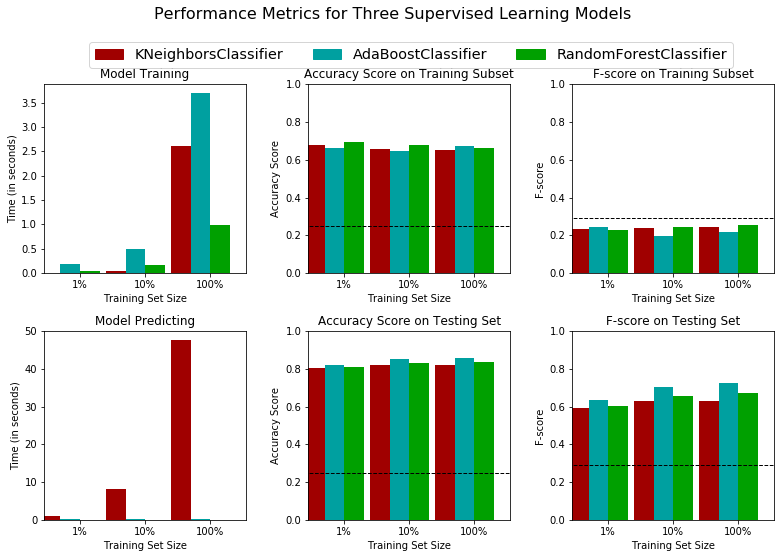

In [12]:
# DONE: Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

# DONE: Initialize the three models
clf_A = RandomForestClassifier(random_state = 50)
clf_B = AdaBoostClassifier(random_state = 50)
clf_C = KNeighborsClassifier()

# DONE: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = X_train.shape[0] * 1/100 
samples_10 = X_train.shape[0] * 10/100
samples_100 = X_train.shape[0] * 100/100

#print samples_1," ",samples_10," ",samples_100," "
# Collect results on the learners
results = {}
for clf in [clf_A,clf_B,clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: ** 
    
 
  |                                  **Perfomance Metrics**                                                          |||||||||||
  |                                           ---                                                                    |||||||||||
  | **Perfomance \  Algorithm**   | **K-nearest-neighbour**  |||  **Ada Boost**   |||  **Random Forest**  |||   ** Best**      |
  | :---------------------------: |  :-------------------:   ||| :--------------: ||| :------------------:|||   :---------:    |
  | :---------------------------: |   1%   |  10%  |  100%   |   1% | 10% | 100%    |  1% | 10%  |  100%    |   :---------:    | 
  |    *Model Training Time*      |   0    | 0.1   |  2.5    |  0.2 | 0.5 | 3.4     | 0.1 | 0.2  |   1.0    | **Random Forest**|
  |  *Accuracy on Training Set*   |   0.65 | 0.63  |  0.65   |  0.63| 0.63| 0.65    | 0.7 | 0.65 | 0.65     | **Random Forest**|
  | *Fbeta score on Training Set* |   0.22 | 0.23  |  0.23   |  0.24| 0.20| 0.22    | 0.25| 0.22 | 0.25     | **Random Forest**|
  |   *Model Predicting Time*     |   1    |  6    |   37    |     0|  0  |   0     |  0.1| 0.1  | 0.1      | **ADA Boost**    |
  |  *Accuracy on Testing Set*    |   0.8  |  0.82 |  0.82   |  0.82| 0.83|  0.84   | 0.81| 0.83 | 0.84     | **ADA Boost**    |
  | *Fbeta score on Testing Set*  |   0.6  | 0.67  |  0.67   |  0.67| 0.69|  0.70   | 0.65| 0.68 | 0.69     | **ADA Boost**    |
  
  
* Based on above performance we can clearly visualise that ***Random forest*** and ***Ada Boost*** are ***performing really well*** while ***K-nearest Neighbour*** is ***out of race***.
* Between Random forest and Ada boost it is very tricky and is close call as we can see :
    * ***Random forest*** is ***outperforming Ada Boost*** ***significantly*** on the ***training data ***
    * ***Ada Boost*** is ***slightly better*** than ***random forest*** on ***testing data.***
* I will go with random forest for this project as i have done researches on both of these algorithm and it is like they both are [somewhat simmilar](https://stats.stackexchange.com/questions/149172/random-forest-vs-adaboost) to each other in a way that they both are ensembler technique but the [major difference](https://stats.stackexchange.com/a/77025) is:
    * Random forest is used to reduce variance from the data while Ada boost is used to reduce bias from the data.
    * Since the given data is i think more prone to high variance i have therefore ***intutively choosen Random Forest***
    

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** While i was studying about the Random Forest I came across this beautiful * [Random Forest - Laymans Introduction](http://blog.echen.me/2011/03/14/laymans-introduction-to-random-forests/). I have taken the cue from this post only and i think this is how it is best choice for this project :

Lets say we have to decide **whether a person X will donate to CharityML or not?**. 

Now suppose we have** a person working in CharityML named Y**. If we ask Y to determines whether X will donate to charity or not.He will first look at all the data given to him which contains features where a ceratin person having certain features donates and other person lagging such features do not.He will then try to generalize the rules from previous data and would ask series of question to X (just like a game of 20 questions). He will ask question like "Is X age > 20 ?" or "Is X married?" or "Is X State-gov worker" and at the end of all these question Y will tell whether X will donate or not by simply answering yes or no to this query. This decision making capabilty of Y is what helps in forming a **decision tree** where each questions become a node of the tree and answer to each question forms a path in the tree that will end in either yes or not at its leaf.

Now we have one decision tree ready but it is prone to errors as Y is only a human being and he can easily make errors. To rectify this we choose some other team members in CharityML, lets say person **P, Q and R**. All of these team members were asked the same question, "Will X donates or not", now we provide a slighly different data to P,Q and R as compared to Y as otherwise they all will reach to same conclusion by asking same series of question(as they all are team members). So instead of giving them same training data we give them different sets of data all of which are correct and have same weights while looking at there individual datas they ask X again 20 questions to check whether he will donate to CharityML or not. Since we have given different sets of data to each team member they will certainly ask different questions to X to reach a conclusion. This will reduce the error as they all have prepared different sets of question and if majority of them says that X will donate then we can rest assure that X is a likely donor and we can send email to him. **All the members** that were added to give a conclusion of the question "Will X donate or not?" **forms there individual decision tree**. We then do voting, on basis of which we decide the final conclusion. All of these **combination of trees forms  a Forest** and since the data that was given to them was **random**, thus this algorithm is termed as **Random Forest**

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [14]:
# DONE: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# DONE: Initialize the classifier
clf = RandomForestClassifier(random_state = 50)

# Done: Create the parameters list you wish to tune
parameters = {'min_samples_split' : [2,3,4,5],'min_samples_leaf' : [1,5,10,50,100,200,500] , 'n_jobs' : [1,-1]}

#print clf.get_params().keys()
# DONE: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=.5,average='micro')

# DONE: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters,scoring=scorer)

# DONE: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5,average='micro'))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5,average='micro'))

Unoptimized model
------
Accuracy score on testing data: 0.8244
F-score on testing data: 0.8410

Optimized Model
------
Final accuracy score on the testing data: 0.8583
Final F-score on the testing data: 0.8583


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.2478         |   0.8244          |   0.8583        |
| F-score        |      0.2917         |   0.8410          |   0.8583        |


**Answer: ** My score are pretty neat now as i have achived more than 80 % accuracy and fscore in unoptimized model and more than 85 % accuracy and fscore in optimized model as compared to 24 % accuracy and 29 % fscore in naive predictior technique. This clearly shows that i have choosen a right model to predict the results and i also have fine tuned it more to increase the accuracy and fscore by significant amount.

Also we can also notice that in unoptimized model the difference between fscore ans accuracy is vey low as compared to naive bayes and it is exaclty same in Optimized model which is preety neat :)


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** I think follwing 5 features are important in providing more predictive power to the model(Ranked from top to bottom) :

1. occupation :
    * I think this is a very important feature as a person who is at very high post in any organisation tend to make most donation.
    
2. age :
     * This is another important feature as people who are above age of 35 or 40 will make more donation as compared to younger people. Also it is generally seen that elder people are at higher post thus it is related to first feature in this way.
3. capital-gain :
    * If a person gains some capital form any source other than his/her income he is likely to donate some part of it to charity and thus becomes an important feature for CharityML.
4. education_level :
     * After age it is also very important what education level the person is having as educated people are more likely to donate than uneducated people
5. marital-status :
    * This is again a great feature to watch out as maried people are less likely to donate as they have to spend most of their salary in running their home as compared to single people, whose expenditure will be less ans thus are likely to donate.


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

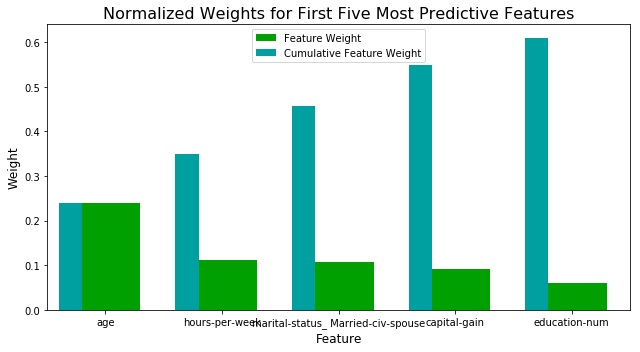

In [15]:
# DONE: Import a supervised learning model that has 'feature_importances_'
# Already using Random Forest

# DONE: Train the supervised model on the training set 
model = RandomForestClassifier(random_state = 50);
model.fit(X_train, y_train)

# DONE: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** I was very SURE that occupation was an important feature but the results are different other than that my intution was correct. Hours per weeks give us the data of how many hours a person is working if a person if working more hours per week then he is definately earning more money hence is more likely to donate money to charity. Though i am amused occupation is not even in the list ;)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [16]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average= 'micro'))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5,average= 'micro'))

Final Model trained on full data
------
Accuracy on testing data: 0.8583
F-score on testing data: 0.8583

Final Model trained on reduced data
------
Accuracy on testing data: 0.8444
F-score on testing data: 0.8444


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** The final fscore and accuracy is slighlty smaller than the accuracy optained on full data model but the difference is only of **0.0139**, if training time was a factor i would definatelty be switching over to reduced data model as earlier i had to wait for like 5 mins to train and predict the answer but on reducing the size i instanly got results and that too very very close to the original score. 

Thus if time constraint was there i would go for reduced data.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.